In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
from itertools import islice
from lib import models
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import tune
from lib.vllm import start_vllm, kill_vllm_workers
import openai
import os
import torch
from transformers import AutoTokenizer

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
# distill_tasks = tasks[:436]
distill_tasks = tasks[:160]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

(160, 72, 92, 436)

In [4]:
model = models.qwen_7b
base_model = model.base_model
tokenizer = AutoTokenizer.from_pretrained(base_model)

distill_client = openai.AsyncOpenAI(
    base_url="https://api.fireworks.ai/inference/v1",
    api_key=os.getenv("FIREWORKS_API_KEY"),
)
distill_model = "accounts/fireworks/models/deepseek-r1"

tokenized_results = [
    result
    for results in await get_task_results(
        tasks=distill_tasks,
        client=distill_client,
        model=distill_model,
        params=ChatCompletionParams(
            max_tokens=2**17,
            logprobs=True,
            top_logprobs=5,
        ),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]
print(
    "Max sequence length:",
    max(len(tokenized_result.token_ids) for tokenized_result in tokenized_results),
)
print(
    "Number of results with no logprobs:",
    sum(
        1
        for tokenized_result in tokenized_results
        if tokenized_result.token_logprobs is None
    ),
)

  0%|          | 0/160 [00:00<?, ?it/s]

Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Max sequence length: 11534
Number of results with no logprobs: 7


Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping


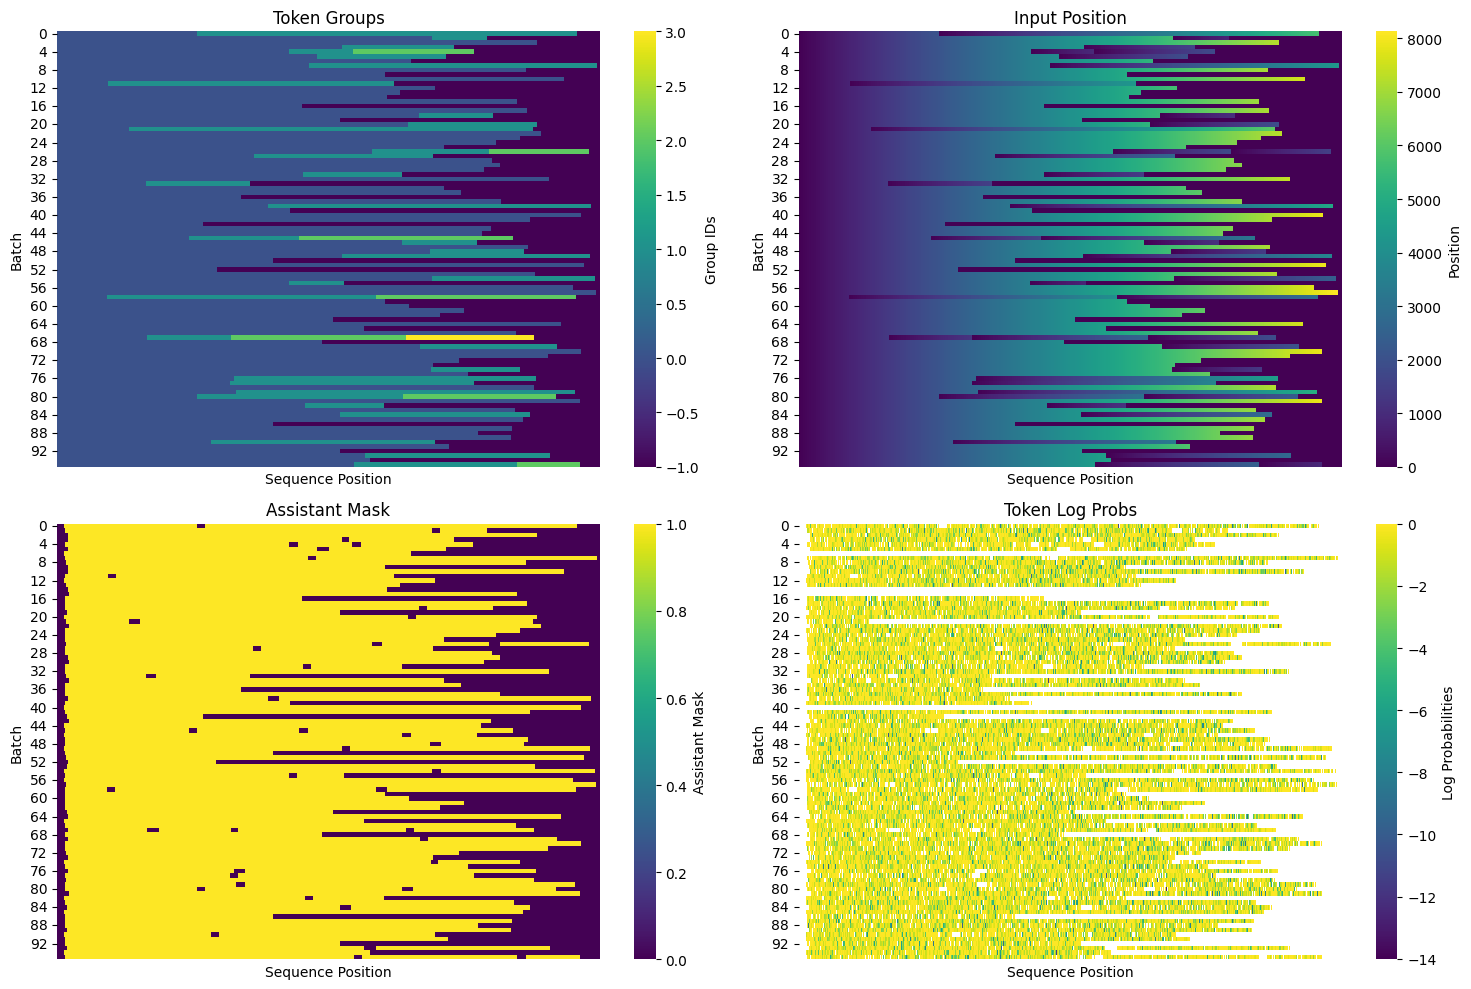

{'tokens': tensor([[151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   2808,  ..., 151643, 151643, 151643],
         [151646, 151644,   1986,  ..., 151643, 151643, 151643],
         ...,
         [151646, 151644,   1986,  ..., 151643, 151643, 151643],
         [151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   9885,  ..., 151643, 151643, 151643]]),
 'group_ids': tensor([[ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         ...,
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1]]),
 'input_pos': tensor([[0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         ...,
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0]]),
 'assistant_mask': tensor([[False, False, False,  ..., False, False, F

In [5]:
seq_len = 8192
packed_tensors = packed_tensors_from_tokenized_results(
    tokenized_results,
    seq_len=seq_len,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
)
plot_packed_tensors(packed_tensors)
packed_tensors

In [6]:
from lib.models import Model
from torchtune.models.qwen2_5 import qwen2_5_7b_base, qwen2_5_14b_base

model = Model(
    base_model="deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    tune_model=qwen2_5_7b_base,
    tune_model_type="QWEN2",
    tune_max_batch_tokens=49152,
    tune_optimizer=ComponentConfig(
        "torch.optim.AdamW",
        lr=2e-5,
        fused=True,
    ),
    vllm_named_arguments={},
)
model = Model(
    base_model="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    tune_model=qwen2_5_14b_base,
    tune_model_type="QWEN2",
    tune_max_batch_tokens=24576,
    tune_optimizer=ComponentConfig(
        "torchao.prototype.low_bit_optim.AdamW8bit",
        lr=2e-5,
    ),
    vllm_named_arguments={},
)

In [ ]:
distilled_model = await tune(
    base_model=model.base_model,
    output_dir="./models/rl1",
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=model.tune_optimizer,
        batch_size=model.tune_max_batch_tokens // seq_len,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=4,
    ),
)

In [7]:
distilled_model = "./models/rl1/0001"

In [21]:
vllm = await start_vllm(
    model.base_model,
    # env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    max_concurrent_requests=512,
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        # enable_chunked_prefill=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        max_num_seqs=128,
        # max_num_batched_tokens=16384,
        num_scheduler_steps=8,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
        tensor_parallel_size=torch.cuda.device_count(),
    ),
    timeout=120 + 15 * torch.cuda.device_count(),
)
vllm

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-14B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=128 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --port=8002 --api-key=default
INFO 02-17 19:39:52 __init__.py:190] Automatically detected platform cuda.
INFO 02-17 19:39:53 api_server.py:840] vLLM API server version 0.7.2
INFO 02-17 19:39:53 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-14B', config='', host=None, port=8002, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_pa

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.23s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:02<00:02,  1.31s/it]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:03<00:01,  1.33s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:04<00:00,  1.00it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:04<00:00,  1.11s/it]



INFO 02-17 19:40:31 model_runner.py:1115] Loading model weights took 13.9476 GB
(VllmWorkerProcess pid=66289) INFO 02-17 19:40:31 model_runner.py:1115] Loading model weights took 13.9476 GB
(VllmWorkerProcess pid=66289) INFO 02-17 19:40:34 worker.py:267] Memory profiling takes 2.70 seconds
(VllmWorkerProcess pid=66289) INFO 02-17 19:40:34 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
(VllmWorkerProcess pid=66289) INFO 02-17 19:40:34 worker.py:267] model weights take 13.95GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.18GiB.
INFO 02-17 19:40:34 worker.py:267] Memory profiling takes 3.02 seconds
INFO 02-17 19:40:34 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-17 19:40:34 worker.py:267] model weights take 13.95GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [65765]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8002 (Press CTRL+C to quit)


INFO 02-17 19:41:24 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-17 19:41:24 metrics.py:455] Avg prompt throughput: 0.8 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-17 19:41:24 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:60968 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


vLLM(client=<openai.AsyncOpenAI object at 0x7f16ba841220>, max_concurrent_tokens=632750, process=<Process 65765>)

In [22]:
tokenized_results = [
    result
    for results in await get_task_results(
        tasks=train_tasks[: 512 // 16],
        client=vllm.client,
        model=model.base_model,
        cache=False,
        log_results=8,
        n=16,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
        ),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]

  0%|          | 0/512 [00:00<?, ?it/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model.base_model)

In [15]:
tokenized_results = [
    result
    for results in await get_task_results(
        tasks=train_tasks[: 512 // 16],
        client=vllm.client,
        model=model.base_model,
        cache=False,
        log_results=8,
        n=16,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
        ),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]

  0%|          | 0/512 [00:00<?, ?it/s]

In [18]:
kill_vllm_workers()

In [17]:
del vllm

Final mask shape: torch.Size([63, 8192, 8192])


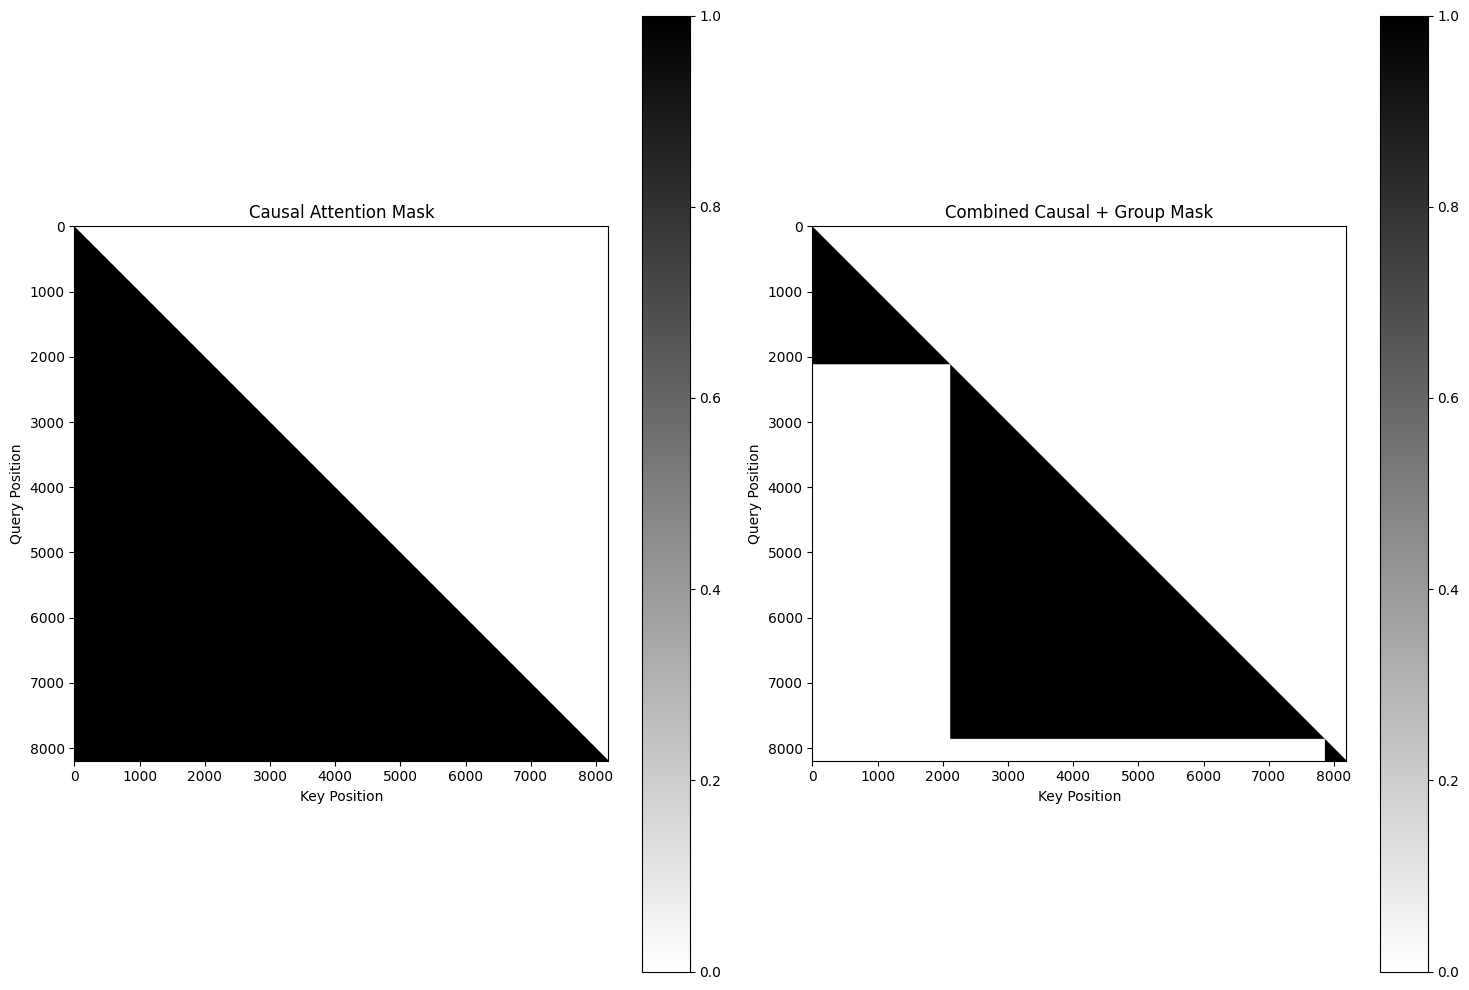

Mask shape: torch.Size([63, 8192, 8192])
Number of allowed attention connections (True values): 1263707944
Percentage of allowed connections: 29.9%


In [10]:
import torch

shape = packed_tensors["tokens"].shape

# Create causal attention mask for the batch size and sequence length
batch_size = shape[0]
seq_length = shape[1]

causal_mask = (
    torch.tril(torch.ones(seq_length, seq_length, dtype=torch.bool))
    .unsqueeze(0)
    .expand(batch_size, seq_length, seq_length)
)
group_mask = packed_tensors["group_ids"].unsqueeze(2) == packed_tensors[
    "group_ids"
].unsqueeze(1)
final_mask = causal_mask & group_mask

# Verify mask shape matches batch size and sequence length
print(f"Final mask shape: {final_mask.shape}")

# Visualize the combined attention mask
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Plot causal mask
mask_example = causal_mask[0].cpu().numpy()
im1 = ax1.imshow(mask_example, cmap="binary")
ax1.set_title("Causal Attention Mask")
ax1.set_xlabel("Key Position")
ax1.set_ylabel("Query Position")
plt.colorbar(im1, ax=ax1)

# Plot combined mask
final_mask_example = final_mask[0].cpu().numpy()
im2 = ax2.imshow(final_mask_example, cmap="binary")
ax2.set_title("Combined Causal + Group Mask")
ax2.set_xlabel("Key Position")
ax2.set_ylabel("Query Position")
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mask shape: {final_mask.shape}")
print(
    f"Number of allowed attention connections (True values): {final_mask.sum().item()}"
)
print(
    f"Percentage of allowed connections: {final_mask.sum().item() / (final_mask.numel()) * 100:.1f}%"
)